In [1]:
from plot_trajectory import plot_paths
import training
import json
import torch
from torch.utils.data import DataLoader
from dataloader import load_val
import joblib
import os
import matplotlib.pyplot as plt
from model_autoregressive import Seq2SeqLSTM
import numpy as np
from tqdm import tqdm

In [2]:
device = training.determine_device()
print("Using device:", device)

Using device: mps


In [3]:
base_path = "results_filtered/results_filtered"
#these jsons files contain the results of different models on the validation set
model_files = [
    "deeper_autoreg_lstm_2_results-2025-11-27T20:29:49.json",
    "deeper_autoreg_lstm_results-2025-11-28T00:57:47.json",
    "deeper_lstm_2_results-2025-11-27T12:05:36.json",
    "deeper_lstm_results-2025-11-27T13:04:46.json",
    "deeper_transformer_2_results-2025-11-27T10:28:16.json",
    "deeper_transformer_results-2025-11-27T11:08:35.json",
    "medium_autoreg_lstm_results-2025-11-27T17:10:27.json",
    "medium_lstm_results-2025-11-27T12:00:40.json",
    "medium_transformer_results-2025-11-27T10:21:55.json",
    "mini_autoreg_lstm_results-2025-11-27T16:42:51.json",
    "mini_lstm_results-2025-11-27T11:44:43.json",
    "mini_transformer_results-2025-11-27T09:44:36.json",
    "small_autoreg_lstm_results-2025-11-27T17:06:56.json",
    "small_lstm_results-2025-11-27T11:50:55.json",
    "small_transformer_results-2025-11-27T10:12:31.json"
]

In [4]:
#find out which (filtered) model performs the best based on MSE on val set
best_model = None
best_val_mse = float('inf')
best_model_data = None

print("Best validation MSE per model:\n")
for f in model_files:
    full_path = os.path.join(base_path, f)
    with open(full_path, "r") as fp:
        data = json.load(fp)
    model_name = data["config"]["name"]
    val_mse = data["history"]["val_mse"]
    model_best_mse = min(val_mse)
    print(f"{model_name:30s}  best MSE = {model_best_mse:.6f}")
    if model_best_mse < best_val_mse:
        best_val_mse = model_best_mse
        best_model = model_name
        best_model_data = data
print("\nOverall best model:")
print(f"{best_model} with best validation MSE = {best_val_mse:.6f}")

Best validation MSE per model:

deeper_autoreg_lstm_2           best MSE = 0.005887
deeper_autoreg_lstm             best MSE = 0.006013
deeper_lstm_2                   best MSE = 0.006291
deeper_lstm                     best MSE = 0.006390
deeper_transformer_2            best MSE = 0.015779
deeper_transformer              best MSE = 0.007193
medium_autoreg_lstm             best MSE = 0.006168
medium_lstm                     best MSE = 0.006685
medium_transformer              best MSE = 0.014190
mini_autoreg_lstm               best MSE = 0.009365
mini_lstm                       best MSE = 0.008681
mini_transformer                best MSE = 0.009885
small_autoreg_lstm              best MSE = 0.006626
small_lstm                      best MSE = 0.007034
small_transformer               best MSE = 0.009385

Overall best model:
deeper_autoreg_lstm_2 with best validation MSE = 0.005887


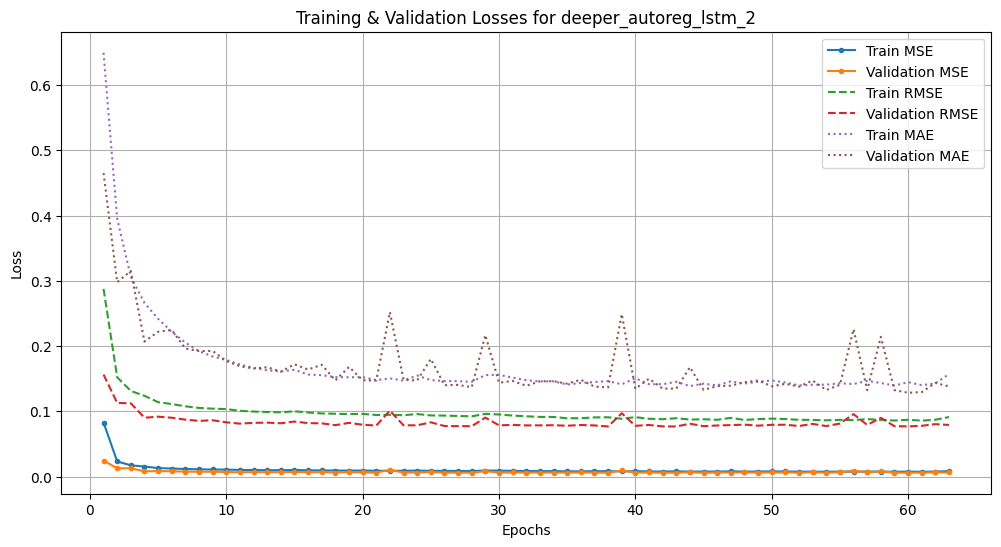

In [5]:
def plot_model_losses(model_data):
    model_name = model_data["config"]["name"]
    history = model_data["history"]
    epochs = range(1, len(history["val_mse"]) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history["train_mse"], label='Train MSE', marker='o', markersize=3)
    plt.plot(epochs, history["val_mse"], label='Validation MSE', marker='o', markersize=3)
    plt.plot(epochs, history["train_rmse"], label='Train RMSE', linestyle='--')
    plt.plot(epochs, history["val_rmse"], label='Validation RMSE', linestyle='--')
    plt.plot(epochs, history["train_mae"], label='Train MAE', linestyle=':')
    plt.plot(epochs, history["val_mae"], label='Validation MAE', linestyle=':')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training & Validation Losses for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage after finding best_model_data:
plot_model_losses(best_model_data)

In [6]:
#load data
batch_size = 512
scaler_filtered = joblib.load("scaler_filtered.save")
val_ds_filtered = load_val(filteringstationary=True, scaler=scaler_filtered)
scaler_unfiltered = joblib.load("scaler_unfiltered.save")
val_ds_unfiltered = load_val(filteringstationary=False, scaler=scaler_unfiltered)
val_loader_filtered = DataLoader(val_ds_filtered, batch_size=batch_size, num_workers=4, shuffle=False)
val_loader_unfiltered = DataLoader(val_ds_unfiltered, batch_size=batch_size, num_workers=4, shuffle=False)

Loading VAL...


100%|██████████| 12847/12847 [00:06<00:00, 2054.45it/s]


Loading VAL...


100%|██████████| 12847/12847 [00:06<00:00, 2021.87it/s]


In [7]:
best_model_path = "deeper_autoreg_lstm_2_best.pt"
full_best_model_path = os.path.join(base_path, best_model_path)

model = Seq2SeqLSTM(**best_model_data["config"]["model_kwargs"]).to(device)
model.load_state_dict(torch.load(full_best_model_path, map_location=device))
model.eval()

Seq2SeqLSTM(
  (encoder_lstm): LSTM(2, 512, num_layers=4, batch_first=True)
  (decoder_lstm): LSTM(2, 512, num_layers=4, batch_first=True)
  (l_out): Linear(in_features=512, out_features=2, bias=True)
)

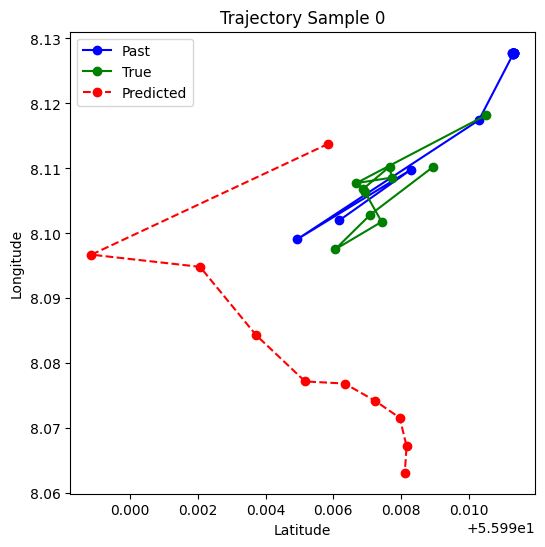

In [11]:
#plot a few samples from the validation set
num_samples_to_plot = 1

# plot
for idx, (x, y) in enumerate(val_loader_filtered):
    if idx >= num_samples_to_plot:
        break
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        y_pred = model(x)
    
    # pick the first element in the batch
    x_np = x[0].cpu().numpy()             # (30,5)
    y_np = y[0].cpu().numpy()             # (10,5)
    y_pred_np = y_pred[0].cpu().numpy().reshape(10, 2)  # reshape flat 50 -> (10,5)

    plot_paths(x_np, y_np, y_pred_np, idx, scaler=scaler_filtered)


In [12]:
# compute per-sample MSE on validation set (notice here we do per-sample MSE, so the total loss is 20 times smaller)
all_mse = []
all_samples = []

for x, y in tqdm(val_loader_filtered, desc="Computing per-sample MSE"):
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        y_pred = model(x)
    
    mse_per_sample = torch.mean((y_pred - y)**2, dim=[1,2])
    all_mse.append(mse_per_sample.cpu().numpy())
    
    for i in range(x.shape[0]):
        all_samples.append({
            "x": x[i].cpu().numpy(),
            "y": y[i].cpu().numpy(),
            "y_pred": y_pred[i].cpu().numpy()
        })

all_mse = np.concatenate(all_mse)
sorted_indices = np.argsort(all_mse)

n = len(all_mse)

Computing per-sample MSE: 100%|██████████| 868/868 [05:54<00:00,  2.45it/s]


In [13]:
percentiles = [10, 30, 50, 80, 90, 95, 99, 100]
print("\nMSE percentile summary:\n")
for p in percentiles:
    threshold = np.percentile(all_mse, p)
    print(f"{p:>3}% of samples have MSE ≤ {threshold:.6f}")


MSE percentile summary:

 10% of samples have MSE ≤ 0.000006
 30% of samples have MSE ≤ 0.000014
 50% of samples have MSE ≤ 0.000029
 80% of samples have MSE ≤ 0.000128
 90% of samples have MSE ≤ 0.000316
 95% of samples have MSE ≤ 0.000660
 99% of samples have MSE ≤ 0.002172
100% of samples have MSE ≤ 9.043044


In [ ]:
groups = {
    "Best": sorted_indices[:3],
    "Q1": sorted_indices[n//4:n//4+3],
    "Median": sorted_indices[n//2:n//2+3],
    "Q3": sorted_indices[3*n//4:3*n//4+3],
    "Worst": sorted_indices[-3:]
}

def plot_sample(sample, title):
    plot_paths(sample["x"], sample["y"], sample["y_pred"], title, scaler=scaler_filtered)

for group_name, indices in groups.items():
    print(f"\nPlotting 3 samples from {group_name} group:")
    for idx in indices:
        plot_sample(all_samples[idx], f"{group_name} Sample (MSE={all_mse[idx]:.6f})")